In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
from tensorflow import keras
import matplotlib.pyplot as plt


### Loading Training and Test Data from Local Directory

Training and test data is loaded from two local .mat files and are formatted into numpy ndarrays.

In [ ]:
# Loading dataset from .mat files
in_ds = sio.loadmat('DS.mat')
labels = sio.loadmat('labels.mat')
in_ds = in_ds['DS']
labels = labels['par']
print(np.shape(in_ds))
print(np.shape(labels))

# Creating a training and test dataset from our data
test_idx = np.random.permutation(in_ds.shape[0])
test_idx = test_idx[:200]
in_ds_tr = np.delete(in_ds, test_idx, 0)
in_ds_ts = in_ds[test_idx, :, :, :]
labels_tr = np.delete(labels, test_idx, 0)
labels_ts = labels[test_idx, :]


### Image and Dataset Preprocessing and Visualization

In [ ]:
def process_image(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label


# Converting numpy ndarrays to datasets
train_ds = tf.data.Dataset.from_tensor_slices((in_ds_tr, labels_tr))
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds = tf.data.Dataset.from_tensor_slices((in_ds_ts, labels_ts))
print('Train size:', train_ds_size)

# Plotting images
plt.figure(figsize=(30, 30))
for i, (image, label) in enumerate(train_ds.take(15)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

# Preprocessing datasets
train_ds = (train_ds.map(process_image).batch(
    batch_size=20, drop_remainder=False))
test_ds = (test_ds.map(process_image).batch(batch_size=len(test_idx)))


### Defining the CNN and FC NN

A keras model is created, along with it's learning parameters, optimizer and loss function. It is compiled and a summary is printed.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(4, (10, 10), input_shape=(
        100, 100, 2), activation='tanh', strides=(3, 3)),
    keras.layers.Conv2D(8, (7, 7), activation='tanh', strides=(2, 2)),
    keras.layers.Conv2D(8, (5, 5), activation='tanh', strides=(2, 2)),
    keras.layers.Conv2D(16, (4, 4), activation='tanh', strides=(1, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(6, activation='linear')
])

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=.9,
    staircase=True)

model.compile(
    loss='mse',
    optimizer=tf.optimizers.Adam(lr_schedule),
    metrics=['accuracy']
)

model.summary()


### Training the CNN FC NN

The model is trained using the training dataset.

In [ ]:
history = model.fit(train_ds, epochs=20)


### Testing and Result Visualization

12.49354463020028 %
17.66714685814633 %
28.720427074898907 %
14.888001840998875 %
29.31208583728849 %
27.57037724638274 %


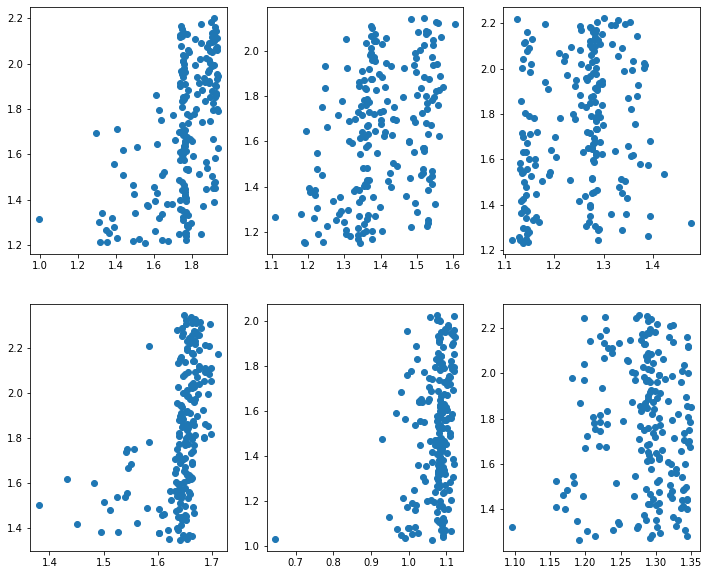

In [11]:
predictions = model.predict(test_ds)
plt.figure(figsize=(12, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.scatter(predictions[:, i], labels_ts[:, i])
    # Mean error
    print(100 * np.average(
        np.abs(predictions[:, i] - labels_ts[:, i]))/np.average(labels_ts[:, i]), "%")